In [1]:
%matplotlib widget
import numpy as np
import torch
import torch.nn as nn
from skimage.measure import label
from skimage.segmentation import find_boundaries
from torch.utils.data import DataLoader
from ipywidgets import interact
import matplotlib
import matplotlib.pyplot as plt

from data.patchwise_dataset import PatchwiseDataset

In [2]:
file_path = "/Volumes/Macintosh HD/Users/davidbruggemann/OneDrive/DIMPEO/data/tmp9_train.h5"

ds = PatchwiseDataset(
        file_path,
        pixelwise=False,
        annual=False,
        spatiotemporal_features=["s2_ndvi", "s2_B04", "s2_B03", "s2_B02"],
        spatial_features=["valid_mask", "drought_mask"],
    )

torch.manual_seed(1)
loader = DataLoader(ds, batch_size=1, drop_last=True, shuffle=True)
loader_iter = iter(loader)

complete_dgs = np.load("complete_dgs.npy")

In [3]:
OUTLIER_FACTOR = 1.5
COUNT_THRESHOLD = 1000
WINDOW_SIZE = 5
NUM_YEARS = 6
NUM_DATAPOINTS_PER_YEAR = 73

In [4]:
plt.rcParams["figure.figsize"] = (16,8)

def browse_images(rgb, ndvi, l_bound, h_bound):
    N = rgb.shape[0]
    ndvi_vmin = ndvi[~torch.isnan(ndvi)].min()
    ndvi_vmax = ndvi[~torch.isnan(ndvi)].max()
    fig, ax = plt.subplots(1, 2, sharey=True)
    im1 = ax[0].imshow(rgb[0])
    im2 = ax[0].imshow(l_bound[0, :, :], cmap=matplotlib.colors.ListedColormap(['white', 'red']), alpha=1.0 * (l_bound[0, :, :] > 0))
    im3 = ax[0].imshow(h_bound[0, :, :], cmap=matplotlib.colors.ListedColormap(['blue', 'white']), alpha=1.0 * (h_bound[0, :, :] > 0))
    im4 = ax[1].imshow(ndvi[0], vmin=ndvi_vmin, vmax=ndvi_vmax)
    im5 = ax[1].imshow(l_bound[0, :, :], cmap=matplotlib.colors.ListedColormap(['white', 'red']), alpha=1.0 * (l_bound[0, :, :] > 0))
    im6 = ax[1].imshow(h_bound[0, :, :], cmap=matplotlib.colors.ListedColormap(['blue', 'white']), alpha=1.0 * (h_bound[0, :, :] > 0))
    fig.colorbar(im4, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle("red: NDVI too low, blue: NDVI too high")
    def update(i=0):
        im1.set_data(rgb[i])
        im2.set_data(l_bound[i, :, :])
        im2.set_alpha(1.0 * (l_bound[i, :, :] > 0))
        im3.set_data(h_bound[i, :, :])
        im3.set_alpha(1.0 * (h_bound[i, :, :] > 0))
        im4.set_data(ndvi[i])
        im5.set_data(l_bound[i, :, :])
        im5.set_alpha(1.0 * (l_bound[i, :, :] > 0))
        im6.set_data(h_bound[i, :, :])
        im6.set_alpha(1.0 * (h_bound[i, :, :] > 0))
        fig.canvas.draw_idle()
    interact(update, i=(0, N-1));

def lin_stretch_vec(band):
    v = torch.nanquantile(band, torch.tensor((0.02, 0.98), dtype=band.dtype))
    temp = 255 * (band - v[0]) / (v[1] - v[0])
    temp = torch.clip(temp, 0, 255)
    return temp

Found 1 anomalies.


interactive(children=(IntSlider(value=0, description='i', max=72), Output()), _dom_classes=('widget-interact',…

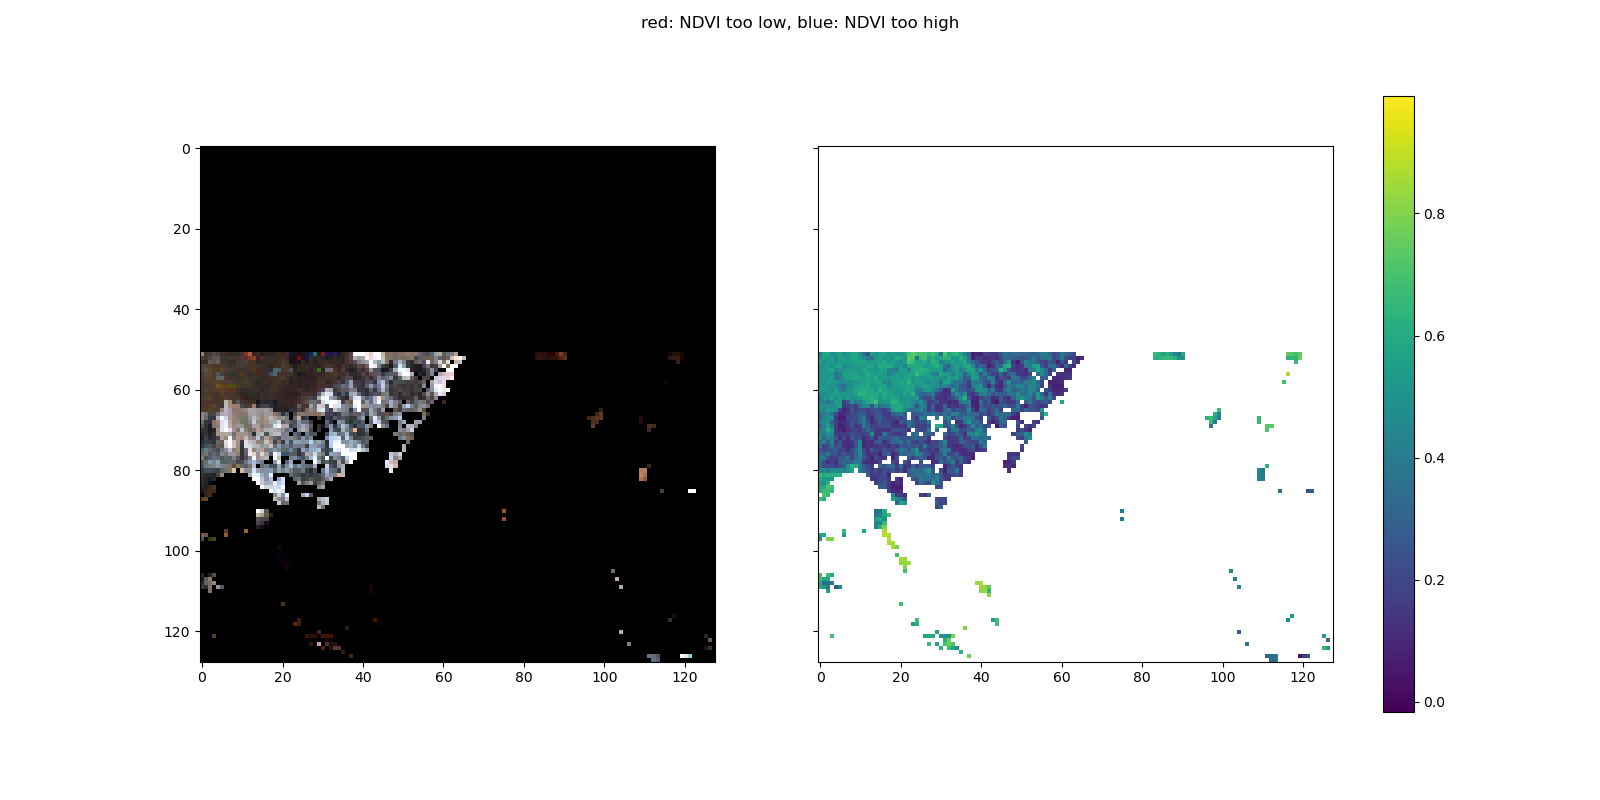

In [5]:
while True:
    try:
        sample = next(loader_iter)
    except StopIteration:
        # reinitialize data loader
        loader_iter = iter(loader)
        sample = next(loader_iter)

    spatiotemporal = sample["spatiotemporal"]
    spatial = sample["spatial"]

    # identify missing entries
    dgs = sample["dgs"][0].tolist()  # assume batch size 1
    missing_idx = []
    for i in range(len(complete_dgs)):
        if complete_dgs[i] != dgs[i]:
            assert not (i == 0 or i == len(complete_dgs) - 1)
            dgs.insert(i, float("nan"))
            missing_idx.append(i)

    # fill in missing data
    for i in range(1, len(missing_idx)):  # only tolerate if there is size 1 gap
        assert missing_idx[i] - missing_idx[i - 1] > 1, "time gap larger than 1"
    B, _, H, W, C = spatiotemporal.shape
    for mid in missing_idx:
        sl = (spatiotemporal[:, mid - 1] + spatiotemporal[:, mid]).unsqueeze(
            1
        ) / 2.0
        spatiotemporal = torch.cat(
            (spatiotemporal[:, :mid], sl, spatiotemporal[:, mid:]), dim=1
        )

    # mask out invalid pixels
    valid_mask = spatial[:, :, :, 0].float()
    spatiotemporal[(valid_mask == 0).view(B, 1, H, W, 1).expand_as(spatiotemporal)] = torch.nan

    # group by day of the year
    spatiotemporal = (
        spatiotemporal.view(B, NUM_YEARS, NUM_DATAPOINTS_PER_YEAR, H, W, C)
        .permute(0, 2, 1, 3, 4, 5)
        .contiguous()
    )
    spatiotemporal = spatiotemporal.view(B * NUM_DATAPOINTS_PER_YEAR, NUM_YEARS, H, W, C)

    # separate fitting set from test
    ndvi = spatiotemporal[:, :, :, :, 0]
    fitset = ndvi[:, :NUM_YEARS - 1]
    testset = ndvi[:, NUM_YEARS - 1]

    padding = int((WINDOW_SIZE - 1) / 2)
    fitset_pad = nn.functional.pad(fitset, (padding, padding, padding, padding), "constant", torch.nan)

    unfold = torch.nn.Unfold(kernel_size=(WINDOW_SIZE, WINDOW_SIZE), dilation=1, padding=0, stride=1)
    fitset_unfold = unfold(fitset_pad)
    valid_mask_unfold = valid_mask.view(1, 1, -1).expand_as(fitset_unfold)

    fitset_unfold[~valid_mask_unfold.bool()] = torch.nan
    q1 = torch.nanquantile(fitset_unfold, 0.25, dim=1)
    q3 = torch.nanquantile(fitset_unfold, 0.75, dim=1)
    iqr = torch.abs(q3 - q1)

    l_thresh = (q1 - OUTLIER_FACTOR * iqr).view(B * NUM_DATAPOINTS_PER_YEAR, H, W)
    h_thresh = (q3 + OUTLIER_FACTOR * iqr).view(B * NUM_DATAPOINTS_PER_YEAR, H, W)

    l_anom = testset < l_thresh
    h_anom = testset > h_thresh

    assert B == 1  # would need to loop through batch elements

    l_labels, l_num = label(l_anom, background=0, connectivity=2, return_num=True)
    for c in range(1, l_num + 1):
        count = np.count_nonzero(l_labels == c)
        if count < COUNT_THRESHOLD:
            l_labels[l_labels == c] = 0
    l_labels[l_labels > 0] = 1

    h_labels, h_num = label(h_anom, background=0, connectivity=2, return_num=True)
    for c in range(1, h_num + 1):
        count = np.count_nonzero(h_labels == c)
        if count < COUNT_THRESHOLD:
            h_labels[h_labels == c] = 0
    h_labels[h_labels > 0] = 1

    anom = l_labels | h_labels

    labels, num = label(anom, background=0, connectivity=2, return_num=True)

    print("Found {} anomalies.".format(num))

    ndvi = testset.squeeze(0)

    red = sample["spatiotemporal"][:, -NUM_DATAPOINTS_PER_YEAR:, :, :, 1].squeeze(0)
    green = sample["spatiotemporal"][:, -NUM_DATAPOINTS_PER_YEAR:, :, :, 2].squeeze(0)
    blue = sample["spatiotemporal"][:, -NUM_DATAPOINTS_PER_YEAR:, :, :, 3].squeeze(0)

    # mask out invalid
    red[(valid_mask == 0).view(1, H, W).expand_as(red)] = torch.nan
    green[(valid_mask == 0).view(1, H, W).expand_as(green)] = torch.nan
    blue[(valid_mask == 0).view(1, H, W).expand_as(blue)] = torch.nan
    red_mask = ~torch.isnan(red)
    green_mask = ~torch.isnan(green)
    blue_mask = ~torch.isnan(blue)
    rgb_mask = red_mask & green_mask & blue_mask

    # R: https://www.rdocumentation.org/packages/raster/versions/3.6-26/topics/plotRGB
    red = lin_stretch_vec(red)
    green = lin_stretch_vec(green)
    blue = lin_stretch_vec(blue)
    rgb = torch.stack((red, green, blue), dim=-1)  # T x H x W x 3
    rgb[~rgb_mask.unsqueeze(-1).expand_as(rgb)] = torch.nan
    rgb = torch.nan_to_num(rgb, nan=0).to(torch.uint8)

    # rgb = torch.stack((red, green, blue), dim=-1)  # T x H x W x 3
    # rgb[~rgb_mask.unsqueeze(-1).expand_as(rgb)] = torch.nan
    # rgb = rgb / 0.2  # Vitus: / 0.4  # Samantha: / 0.22
    # rgb = torch.clip(rgb, 0.0, 1.0)
    # rgb = torch.nan_to_num(rgb, nan=0)

    l_boundaries = find_boundaries(l_labels, mode='outer').astype(float)  # T x H x W
    h_boundaries = find_boundaries(h_labels, mode='outer').astype(float)  # T x H x W

    # if num > 0:
    break

browse_images(rgb, ndvi, l_boundaries, h_boundaries)